# Modelling Rumors based on the CREDBANK Dataset

The following notebook describes the process of training the Support Vector Classifier to determine if a tweet contains a rumor or not.

## Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import figure
from sklearn.model_selection import train_test_split
import regex as re
import string
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

import pickle

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/kl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Extraction

In [7]:
df = pd.read_csv('../datasets/final_train_data.csv')

In [8]:
df.head()

,id,is_credible,text
0,5.228430e+17,0,RT @onedirection: The guys are up for 3 #AMAs ...
1,5.252810e+17,0,RT @Marvel: Here it is! Watch the @Avengers: #...
2,5.637530e+17,0,"""This is another PR stunt by ISIS,"" Jordanian ..."
3,5.656020e+17,0,RT @Independent: The media ignored the #Chapel...
4,5.507820e+17,0,RT @rivalsmike: Wow “@JeffPassan: Baylor kicke...


In [9]:
df.dtypes

id             float64
is_credible      int64
text            object
dtype: object

In [10]:
df.shape

(344200, 3)

In [11]:
# Drop any null rows
df.dropna(inplace=True)

In [13]:
X = df['text']
y = df['is_credible']

In [14]:
# Distribution of is_credible (1=True, 0=False)
y.value_counts(normalize=True)

1    0.709384
0    0.290616
Name: is_credible, dtype: float64

Baseline Accuracy is 70.9%

In [15]:
# Double check there are no null values
X.isnull().sum()

0

In [16]:
y.isnull().sum()

0

## Split Data into Testing & Training

In [17]:
# Create train-test split, 77 training: 33 testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Exploratory Data Analysis

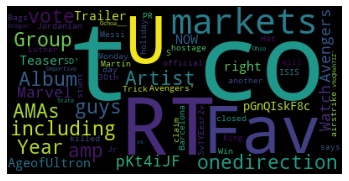

In [18]:
text = df['text'].values 

#Create a word cloud showing the most common words in the tweets
wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

"RT" refers to re-tweet which makes sense that the majority of tweets would be referencing another

## Cleaning & Vectorizing

In [19]:
# Function to clean each text string
def cleaning(text):

    #lowercase all characters
    text = text.lower()
    
    #remove links
    text = re.sub('https?://\S+|www\.\S+', '', text) 
    
    #Remove special characters
    text = re.sub('<.*>+', '', text) 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
    text = re.sub('[„»â€™]', '', text)
    
    #tokenize and re-join
    text_tokens = word_tokenize(text)
    filtered_sentence = (" ").join(text_tokens)
    text = filtered_sentence
    return text #return cleaned sentences

In [20]:
# Apply cleaning function to the testing and training data
X_train_c = X_train.apply(cleaning)
X_test_c = X_test.apply(cleaning)

In [21]:
X_train_c.head()

314520    rt ohiostatemhky buckeyes win final ohio state...
146589    sad rtcnnbrk at least 12 killed in todays atta...
19798     ❤️ mãe rindo hahaha chrisbrown favorite male s...
127278    rt ashleyfires mlkday2015 take time to honorth...
291052    rt wsoctv video dash cam captures transasia pl...
Name: text, dtype: object

In [23]:
# Vectorize X test and train with Term Frequency-Inverse Document Frequency (TFIDF)
tvec = TfidfVectorizer()
X_train_tv = tvec.fit_transform(X_train_c)

X_test_tv = tvec.transform(X_test_c)

## Initial Classification Model Evaluation

Primarily evaluating classification models with default settings

In [24]:
# Multinomial Bayes
mnb = MultinomialNB()
print('MNB')
print(f"CV score: {cross_val_score(mnb, X_train_tv, y_train, cv=5).mean()}")
mnb.fit(X_train_tv, y_train)
print(f"Train Score: {mnb.score(X_train_tv, y_train)}")
print(f"Test Score: {mnb.score(X_test_tv, y_test)}")

# # RESULTS SAVED INCASE OF RE-RUN
# MNB
# CV score: 0.9497211776991202
# Train Score: 0.9585758019894716
# Test Score: 0.9503459933442502

MNB
CV score: 0.9497211776991202
Train Score: 0.9585758019894716
Test Score: 0.9503459933442502


In [25]:
# Support Vector Classification
print('SVC Machine')
svc = SVC()
print(f"CV score: {cross_val_score(svc, X_train_tv, y_train, cv=5).mean()}")
svc.fit(X_train_tv, y_train)
print(f"Train Score: {svc.score(X_train_tv, y_train)}")
print(f"Test Score: {svc.score(X_test_tv, y_test)}")

# # RESULTS SAVED INCASE OF RE-RUN
# SVC Machine
# CV score: 0.9824121699281134
# Train Score: 0.9918001509015064
# Test Score: 0.9829732537460603

SVC Machine
CV score: 0.9824121699281134
Train Score: 0.9918001509015064
Test Score: 0.9829732537460603


In [26]:
# Random Forest Classifier
rf = RandomForestClassifier()
print('Random Forest')
print(f"CV score: {cross_val_score(rf, X_train_tv, y_train, cv=5).mean()}")
rf.fit(X_train_tv, y_train)
print(f"Train Score: {rf.score(X_train_tv, y_train)}")
print(f"Test Score: {rf.score(X_test_tv, y_test)}")

# # RESULTS SAVED INCASE OF RE-RUN
# Random Forest
# CV score: 0.979003879652222
# Train Score: 0.9960063135802684
# Test Score: 0.9784216364692832

Random Forest
CV score: 0.979003879652222
Train Score: 0.9960063135802684
Test Score: 0.9784216364692832


In [28]:
# Bagging Classifier
bag = BaggingClassifier()
print('Bagging')
print(f"CV score: {cross_val_score(bag, X_train_tv, y_train, cv=5).mean()}")
bag.fit(X_train_tv, y_train)
print(f"Train Score: {bag.score(X_train_tv, y_train)}")
print(f"Test Score: {bag.score(X_test_tv, y_test)}")

# RESULTS SAVED INCASE OF RE-RUN
# Bagging
# CV score: 0.9712067682515506
# Train Score: 0.9948614544035385
# Test Score: 0.972972972972973

In [29]:
# Ada Boost Classifier
ada = AdaBoostClassifier()
print('Ada')
print(f"CV score: {cross_val_score(ada, X_train_tv, y_train, cv=5).mean()}")
ada.fit(X_train_tv, y_train)
print(f"Train Score: {ada.score(X_train_tv, y_train)}")
print(f"Test Score: {ada.score(X_test_tv, y_test)}")

# # RESULTS SAVED INCASE OF RE-RUN
# Ada
# CV score: 0.9523871366554083
# Train Score: 0.9537097263778674
# Test Score: 0.952460603926402

In [30]:
# K Nearest Neighbors Classifier
knn = KNeighborsClassifier()
print('KNN')
print(f"CV score: {cross_val_score(knn, X_train_tv, y_train, cv=5).mean()}")
knn.fit(X_train_tv, y_train)
print(f"Train Score: {knn.score(X_train_tv, y_train)}")
print(f"Test Score: {knn.score(X_test_tv, y_test)}")

# RESULTS SAVED INCASE OF RE-RUN
# KNN
# CV score: 0.8379733204530657
# Train Score: 0.8814665452495555
# Test Score: 0.8623118232238753

In [31]:
# Decision Tree Classifier
dt = DecisionTreeClassifier()
print('Decision Tree')
print(f"CV score: {cross_val_score(dt, X_train_tv, y_train, cv=5).mean()}")
dt.fit(X_train_tv, y_train)
print(f"Train Score: {dt.score(X_train_tv, y_train)}")
print(f"Test Score: {dt.score(X_test_tv, y_test)}")

# RESULTS SAVED INCASE OF RE-RUN
# Decision Tree
# CV score: 0.9689952357112469
# Train Score: 0.9969212089675209
# Test Score: 0.9691874284708161

From these initial results, SVC was chosen. Below is further tuning of the model.

## Stemmer

In [33]:
# Creating a stemming function
# Choice of snowball as it imporves upon Porter but is not as strict as Lancaster
from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='english') 

analyzer = TfidfVectorizer().build_analyzer()

def stemmed_snow(doc):
    return (s_stemmer.stem(w) for w in analyzer(doc))

## Hyperparamter Tuning with GridSearchCV

In [19]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

In [20]:
pipe_params = {
     'tvec__max_features' : [1000, 2000], 
     'tvec__min_df' : [5], 
     'tvec__max_df' : [0.95],
     'tvec__analyzer' : [None, stemmed_snow], 
    
      # 'svc__C': [0.5, 0.9, 1.5],
      # 'svc__gamma': [0.5, 1, 2],
      # 'svc__kernel': ['rbf']
}

In [21]:
gs = GridSearchCV(pipe,param_grid = pipe_params, cv=3, verbose = 1, n_jobs = -1)

In [22]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/kl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kl/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/kl/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/kl

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'tvec__analyzer': [None,
                                            <function stemmed_snow at 0x7fb764c3dca0>],
                         'tvec__max_df': [0.95],
                         'tvec__max_features': [1000, 2000],
                         'tvec__min_df': [5]},
             verbose=1)

In [23]:
gs.best_params_

{'tvec__analyzer': <function __main__.stemmed_snow(doc)>,
 'tvec__max_df': 0.95,
 'tvec__max_features': 2000,
 'tvec__min_df': 5}

In [35]:
pred_ = gs.predict(X_test)
print(f"Train Score: {gs.score(X_train, y_train)}")
print(f"Test Score: {gs.score(X_test, y_test)}")

# # RESULTS SAVED INCASE OF RE-RUN
# Train Score: 0.9941893239668704
# Test Score: 0.9763623558411832

In [36]:
tn, fp, fn, tp = confusion_matrix(y_test, pred_).ravel()
print(f"True Negatives: {tn}")
print(f"Fale Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print("")
Accuracy = (tp+tn)/(tp+fp+fn+tn)
print(f"Accuracy: {Accuracy}")

# # RESULTS SAVED INCASE OF RE-RUN
# True Negatives: 6249
# Fale Positives: 382
# False Negatives: 155
# True Positives: 15932

# Accuracy: 0.9763623558411832

## Save Model

In [24]:
gs_best = gs.best_estimator_
gs_best.fit(X_train, y_train)

with open('svc_model.pickle', 'wb') as pfile:
    pickle.dump(gs_best, pfile, protocol=pickle.HIGHEST_PROTOCOL)

### TEST

In [11]:
# TEST
sample_text = ["hello34931820 i'm92 m39iss93ing m*(&@y c@@at"]
def stemmed_snow(doc):
    s_stemmer = SnowballStemmer(language='english') 
    analyzer = TfidfVectorizer().build_analyzer()
    return (s_stemmer.stem(w) for w in analyzer(doc)) 

with open('pretrained_models/svc_model.pickle', 'rb') as handle:
    model = pickle.load(handle)
    
    
preds = model.predict(sample_text)
preds[0]

1

In [12]:
# TEST 2
sample_text = ['hurricane Katrina destroyed half the Earth']
preds = model.predict(sample_text)
preds[0]

1

TEST RESULTS
ACCURACY: 0.8316831683168316
F1 SCORE: 0.8045977011494254
ROC AUC: 0.830392156862745


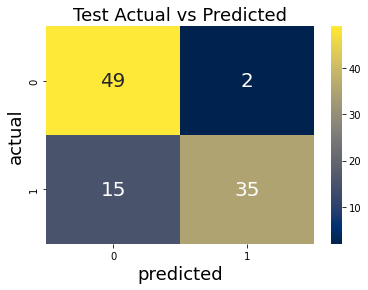

In [11]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Testing randomized pre-labeled test dataset
test = pd.read_csv('../datasets/validation_data.csv', lineterminator='\n')

# Predictions
test['predictions'] = model.predict(test['text'])

# Scores
acc = accuracy_score(test['is_credible'], test['predictions'])
f1 = f1_score(test['is_credible'], test['predictions'])
roc_auc = roc_auc_score(test['is_credible'], test['predictions'])

print('TEST RESULTS')
print(f'ACCURACY: {acc}')
print(f'F1 SCORE: {f1}')
print(f'ROC AUC: {roc_auc}')

# Confusion matrix
cm = confusion_matrix(test['is_credible'], test['predictions'])
sns.heatmap(cm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title('Test Actual vs Predicted', fontsize=18)
plt.show()

TEST RESULTS
ACCURACY: 0.518
F1 SCORE: 0.639760837070254
ROC AUC: 0.518


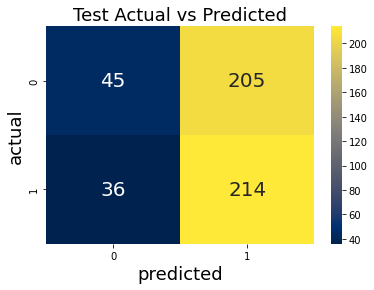

In [13]:
# Random wildfire dataset
test = pd.read_csv('../datasets/california_wildfires.csv')

# Predictions
test['predictions'] = model.predict(test['text'])

# Scores
acc = accuracy_score(test['is_credible'], test['predictions'])
f1 = f1_score(test['is_credible'], test['predictions'])
roc_auc = roc_auc_score(test['is_credible'], test['predictions'])
cm = confusion_matrix(test['is_credible'], test['predictions'])

print('TEST RESULTS')
print(f'ACCURACY: {acc}')
print(f'F1 SCORE: {f1}')
print(f'ROC AUC: {roc_auc}')

# Confusion matrix
sns.heatmap(cm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title('Test Actual vs Predicted', fontsize=18)
plt.show()